In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Import processed DataFrames:
This notebook correlates Covid 19 test results and hospitalizations for individual counties for over a sequence of months
* **cases** counts reported positive Covid 19 tests of US counties over a sequence of weeks
* **counties** provides the identity and geometry of each US county
* **hospitalizations** provdes the count of reported hospitalilzed Covid 19 patients for each hospital over a sequenceof months
* **hospitals** provides the identity and geometry of US hospitals submiting Covid 19 reports

In [2]:
cases = pd.read_pickle('../../pickles/CDCpickles/cases.pkl')
counties = pd.read_pickle('../../pickles/CDCpickles/counties_plus.pkl')
hospitals = pd.read_pickle('../../pickles/CDCpickles/hospitals.pkl')
hospitalizations = pd.read_pickle('../../pickles/CDCpickles/hospitalizations.pkl')

## Identify Silent & Reporting Counties
From cases notebook, we know some number of counties were silent (submitted no cases). Furthermore, we need to establish our confidence level in those counties that did.

In [3]:
silent_counties, reporting_counties = [x for _, x in counties.groupby(counties.index.isin(cases.index.droplevel('month')))]

<AxesSubplot:>

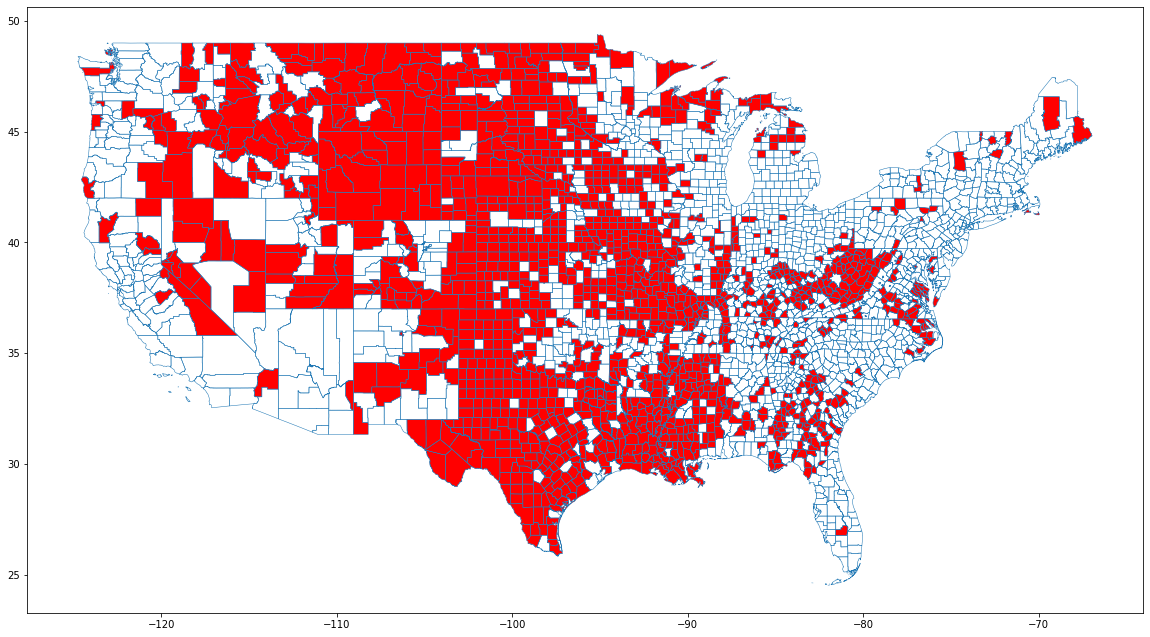

In [4]:
# Plot silent counties (i.e., those that submitted no Covid 19 case reports)
base = counties.boundary.plot(figsize=(20,20), linewidth=0.5)
silent_counties.plot(color='red', ax=base)

# Seem fairly rural

In [5]:
# Total population of silent counties?
pop_total = counties['pop'].sum()
pop_silent = silent_counties['pop'].sum()
print('total population:', pop_total)
print('population in silent counties:', pop_silent, '-->', f'{pop_silent/pop_total:.2%}')

total population: 326092106
population in silent counties: 34999575 --> 10.73%


In [6]:
# Of reporting (non-silent) counties, how many have no hospital?
reporting_counties['hospitals'].map(len).value_counts().sort_index()

# 121... the cases from these need to be assigned evenly amongst surrounding counties that have hospitals

0     121
1     743
2     302
3     125
4      67
5      39
6      31
7      18
8      12
9       7
10     11
11      8
12      6
13      7
14      2
15      3
16      2
17      3
19      3
20      1
21      3
25      1
26      1
28      2
40      1
46      1
50      1
87      1
Name: hospitals, dtype: int64

In [7]:
# Do any of the 121 reporting counties w/out a hospital have no neighbors with hospitals?
reporting_counties[(reporting_counties['hospitals'].map(len) == 0) & (reporting_counties['neighbors_wHosp'].map(len) == 0)]

# Amongst the reporting counties with no hospital, every single one has at least 1 neighboring county with a hospital.
# We will distribute their cases evenly to their neighbors with hospitals.
# The 3 hospital-less counties with hospital-less neighbors identified in the counties notebook are apparrently silent.

,state_name,county_name,area,geometry,hospitals,neighbors,neighbors_wHosp,pop,density
FIPS,,,,,,,,,


In [8]:
# Terribly curious, what county has 87 hospitals?
reporting_counties.sort_values(by='hospitals', key=np.vectorize(len), ascending=False)[:5]

# Ah, Los Angeles!

,state_name,county_name,area,geometry,hospitals,neighbors,neighbors_wHosp,pop,density
FIPS,,,,,,,,,
06037,California,Los Angeles,10513491099,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987...","[050040, 050056, 050058, 050063, 050078, 05009...","[06059, 06071, 06111, 06029]","[06059, 06071, 06111, 06029]",10039107,954.878537
17031,Illinois,Cook,2447350649,"POLYGON ((-88.26364 42.06687, -88.25835 42.066...","[140008, 140010, 140018, 140048, 140049, 14005...","[17197, 18089, 17043, 17097, 17089, 17111]","[17197, 18089, 17043, 17097, 17089, 17111]",5150233,2104.411561
48201,Texas,Harris,4421015900,"MULTIPOLYGON (((-94.97839 29.68365, -94.97743 ...","[450035, 450068, 450076, 450097, 450184, 45019...","[48473, 48071, 48039, 48167, 48339, 48157, 48291]","[48071, 48039, 48167, 48339, 48157, 48291]",4713325,1066.118084
04013,Arizona,Maricopa,23832530727,"POLYGON ((-113.33505 33.55195, -113.33505 33.5...","[030002, 030014, 030022, 030024, 030030, 03003...","[04012, 04027, 04025, 04021, 04007, 04019]","[04012, 04027, 04025, 04021, 04007, 04019]",4485414,188.205527
48113,Texas,Dallas,2261201323,"POLYGON ((-97.03852 32.56000, -97.03840 32.566...","[450015, 450021, 450044, 450051, 450079, 45037...","[48139, 48121, 48085, 48397, 48439, 48257]","[48139, 48121, 48085, 48397, 48439, 48257]",2635516,1165.537970


In [9]:
# How many of reported cases are from counties wtih no hospital?
reporters_noHosp = reporting_counties[reporting_counties['hospitals'].map(len) == 0]

cases_noHosp = 0
for idx, row in cases.iterrows():
    if idx[0] in reporters_noHosp.index:
        cases_noHosp += row['case_count']

total_positives = cases['case_count'].sum()
print('Total positive cases:', total_positives)
print('Positive cases is counties without hospital:', cases_noHosp, '-->', f'{cases_noHosp/total_positives:.2%}')

# Very few

Total positive cases: 26244535
Positive cases is counties without hospital: 460206 --> 1.75%


## Distribute Cases From No-Hospital Counties

**The cases from counties with no hospitals get randomly added to their neighboring county's cases, distributed randomly but evenly.**
* This re-distribution is performed in the order of zero-hospital counties with fewer neighbors first.
* All cases within a given county (and added from neighboring no-hospital counties) are summed together, we do not distinguish between hospitals in the same county.

If we simply did not count cases from counties with no hospitals, counts would be deflated on average to 98.25% of the available cases. This is not horrible, but I think we can impose a relatively painless correction: Distribute case counts from counties without hospitals evenly amongst their neighbors with hospitals. This way, all reported cases are compared to some nearby hospital's patient counts.

In [10]:
cases_adjusted = cases.copy()
labels_to_drop = []

for idx, row in cases.iterrows():
    
    # Check if cases are from a county with no hospital
    if idx[0] in reporters_noHosp.index:
        
        # If 'yes', get list of neighbors with hospitals
        neighbors_wHosp = counties.loc[idx[0], 'neighbors_wHosp']
        
        # ...then split up cases evenly
        split = row['case_count'] // len(neighbors_wHosp)
        
        # ...and add the splits to those neighbors' case_counts
        for i in neighbors_wHosp:

            # Note: i is neighboring county's fips code...
            # and idx[1] (2nd level of cases index) is the month the cases were tallied
            if (i, idx[1]) in cases.index:  
                cases_adjusted.loc[(i, idx[1]), 'case_count'] += split
            else:
                cases_adjusted.loc[(i, idx[1]), 'case_count'] = split
                
        # gather redistributed cases
        labels_to_drop.append(idx)
        
# ...and drop them
cases_adjusted = cases_adjusted.drop(labels_to_drop)
# cases_adjusted = cases_adjusted.reset_index(level='month')

# Uh, for some reason cases_adjusted['case_count'] type flipped to floats... change back to int
cases_adjusted['case_count'] = cases_adjusted['case_count'].astype('int64')

print('orignial count of reported cases:', cases['case_count'].sum())
print('adjusted count of reported cases:', cases_adjusted['case_count'].sum())
cases_adjusted

orignial count of reported cases: 26244535
adjusted count of reported cases: 26233674


case_count
FIPS  month              
01001 2020-03          16
      2020-04          40
      2020-05         154
      2020-06         326
      2020-07         480
...                   ...
55091 2021-03          38
      2021-04          48
      2021-05          14
      2021-06           2
      2021-07           1

[23355 rows x 1 columns]

## Add Patients to Cases DataFrame
For a given county (i.e., FIPS) during a given month, count all hospitalizations occuring that month in all of that county's hospitals. Hospitalization counts are aggregated into weeks. For weeks that span two months, we'll split up the patients between the two months proportional to the number of the week's days in each.

In [11]:
hospitalizations

,hospital_pk,collection_week,patients
254671,010001,2020-07-31/2020-08-06,26.0
249774,010001,2020-08-07/2020-08-13,46.0
244925,010001,2020-08-14/2020-08-20,36.0
240065,010001,2020-08-21/2020-08-27,40.0
235164,010001,2020-08-28/2020-09-03,39.0
...,...,...,...
215400,fa96db24d19f83993a2925454eafc6fa17dd8e64270534...,2020-09-25/2020-10-01,6.0
210430,fa96db24d19f83993a2925454eafc6fa17dd8e64270534...,2020-10-02/2020-10-08,4.0
205459,fa96db24d19f83993a2925454eafc6fa17dd8e64270534...,2020-10-09/2020-10-15,13.0
200474,fa96db24d19f83993a2925454eafc6fa17dd8e64270534...,2020-10-16/2020-10-22,2.0


In [12]:
hospitalizations['patients'].sum()

4612874.0

In [13]:
# Let's add each counties list of hospitals to cases_adjusted for speed of calculating patient counts
cases_adjusted = cases_adjusted.merge(reporting_counties['hospitals'],left_index=True, right_index=True)
cases_adjusted.head()

case_count hospitals
FIPS  month                        
01001 2020-03          16  [010108]
      2020-04          40  [010108]
      2020-05         154  [010108]
      2020-06         326  [010108]
      2020-07         480  [010108]

In [14]:
def get_patient_counts(week):
    counts = []
    fips = hospitals.loc[week['hospital_pk'], 'county']
    month = pd.Period(week['collection_week'].start_time, freq='M')
    patient_count = week['patients']
    
    if week['collection_week'].start_time.month == week['collection_week'].end_time.month:
        return [(fips, month, patient_count)]
        
    else:
        days_in_opening_month = (month.end_time - week['collection_week'].start_time).days + 1
        patients_in_opening_month = patient_count * days_in_opening_month / 7
        return [(fips, month, patients_in_opening_month), (fips, month + pd.offsets.MonthEnd(), patient_count - patients_in_opening_month)]
        
    return counts

In [15]:
temp = hospitalizations.apply(get_patient_counts, axis=1)

In [16]:
temp_df = pd.DataFrame([x for sublist in temp.values for x in sublist], columns=['FIPS', 'month', 'patient_count'])
temp_sr = temp_df.groupby(['FIPS', 'month'])['patient_count'].sum().astype(int)
temp_sr

FIPS   month  
01001  2020-07      0
       2020-08     72
       2020-09     72
       2020-10    100
       2020-11    122
                 ... 
56045  2021-03     15
       2021-04      0
       2021-05      0
       2021-06      0
       2021-07     10
Name: patient_count, Length: 31437, dtype: int32

In [17]:
cases_adjusted = cases_adjusted.merge(temp_sr, how='left', left_index=True, right_index=True)

In [18]:
cases_adjusted['patient_count'] = cases_adjusted['patient_count'].fillna(0).astype(int)

In [19]:
cases_adjusted[0:10]

case_count hospitals  patient_count
FIPS  month                                       
01001 2020-03          16  [010108]              0
      2020-04          40  [010108]              0
      2020-05         154  [010108]              0
      2020-06         326  [010108]              0
      2020-07         480  [010108]              0
      2020-08         387  [010108]             72
      2020-09         331  [010108]             72
      2020-10         393  [010108]            100
      2020-11         733  [010108]            122
      2020-12        1412  [010108]            192

In [20]:
# Are all the patients reported by the hospitals in a given county have a corresponding report of cases in that county?
# In other words, in the left join (merge) above, were any patients dropped because there was no corresonding FIPS/month records in cases_adjusted?
cases_adjusted['patient_count'].sum()

# Indeed, only 3.9M of the original 4.6M had corresponding cases
# Note: It can be confirmed that the patients were all present until the merge with the cases_adjusted dataframe

3911344

## Analyze Cases Vs Patients

In [21]:
cases_summary = cases_adjusted.reset_index().groupby('month')[['case_count', 'patient_count']].sum().reset_index()
cases_summary['month'] = cases_summary['month'].map(lambda x: x.to_timestamp())
cases_summary

,month,case_count,patient_count
0,2020-01-01,2330,0
1,2020-02-01,2949,0
2,2020-03-01,349806,0
3,2020-04-01,749237,0
4,2020-05-01,646144,0
5,2020-06-01,847266,0
6,2020-07-01,1305339,9909
7,2020-08-01,986424,304285
8,2020-09-01,918246,267911
9,2020-10-01,1643809,319098


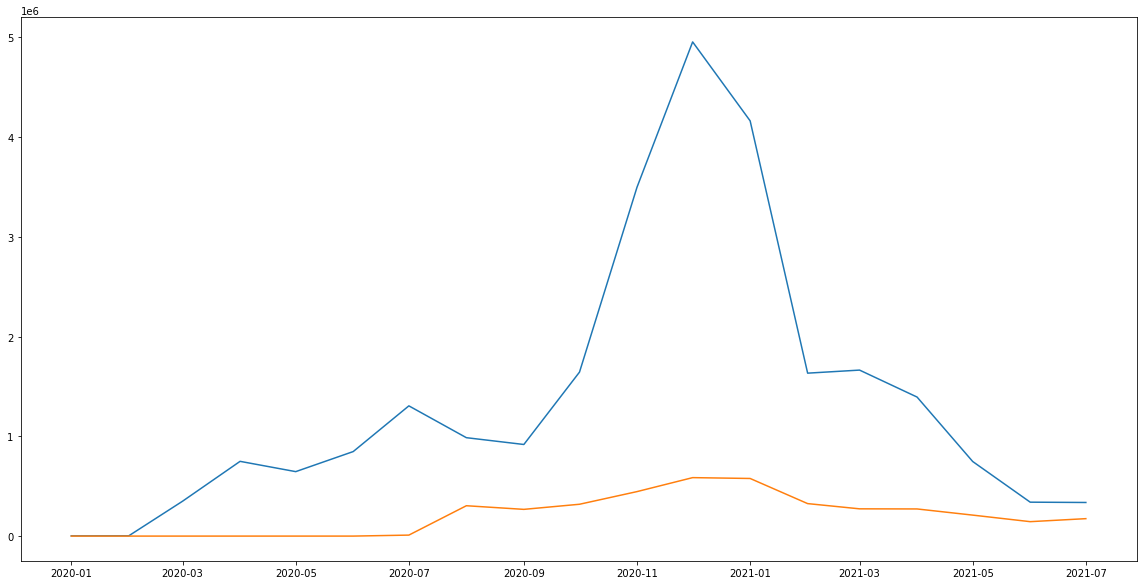

In [22]:
plt.figure(figsize=(20,10))
plt.plot(cases_summary['month'], cases_summary['case_count'])
plt.plot(cases_summary['month'], cases_summary['patient_count'])

In [23]:
cases_summary['percent'] = 100 * cases_summary['patient_count'] / cases_summary['case_count']

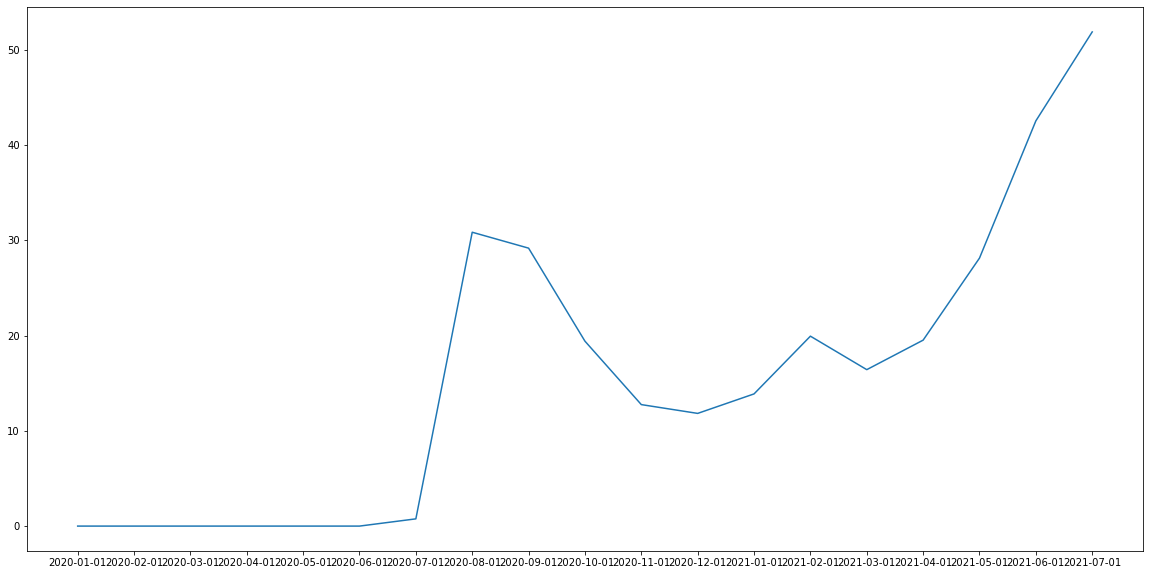

In [24]:
plt.figure(figsize=(20,10))
plt.plot(cases_summary['month'].astype(str), cases_summary['percent'])

## Hospitalizations vs Deaths
Deaths from United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv from CDC. This data provides count of Covid 19 deaths for every state per day for the last 586 days.

In [25]:
deaths_raw = pd.read_csv('../../data/CDCdata/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv', parse_dates=['submission_date'])
deaths_raw

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,2021-01-25,NE,187923,NaN,NaN,646,0.0,1894,NaN,NaN,15,0.0,01/27/2021 12:00:00 AM,Not agree,Not agree
1,2021-02-02,IL,1130917,1130917.0,0.0,2304,0.0,21336,19306.0,2030.0,63,16.0,02/03/2021 02:55:58 PM,Agree,Agree
2,2020-07-30,ME,3910,3497.0,413.0,22,2.0,123,122.0,1.0,2,0.0,07/31/2020 02:35:06 PM,Agree,Agree
3,2020-06-15,WI,25480,22932.0,2548.0,185,11.0,700,694.0,6.0,2,0.0,06/16/2020 02:10:11 PM,Agree,Agree
4,2020-07-31,ND,6602,6602.0,0.0,133,0.0,103,NaN,NaN,0,0.0,08/01/2020 02:38:12 PM,Agree,Not agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35155,2020-07-17,SC,65995,65545.0,450.0,1999,42.0,1197,NaN,NaN,34,1.0,07/17/2020 12:00:00 AM,Agree,Not agree
35156,2020-07-19,NJ,178541,NaN,NaN,-10,21.0,15706,13732.0,1974.0,34,27.0,07/19/2020 12:00:00 AM,Not agree,Agree
35157,2021-02-10,FSM,1,1.0,0.0,0,0.0,0,0.0,0.0,0,0.0,02/11/2021 02:50:55 PM,Agree,Agree
35158,2021-03-12,KY,420869,321763.0,99106.0,691,193.0,6781,6075.0,706.0,13,1.0,03/14/2021 12:00:00 AM,Agree,Agree


In [26]:
deaths = pd.DataFrame(deaths_raw.groupby('submission_date')[['new_death', 'new_case']].sum()).sort_index()
deaths = deaths.resample('MS').sum().reset_index()
deaths

,submission_date,new_death,new_case
0,2020-01-01,0,51
1,2020-02-01,4,496
2,2020-03-01,5139,226640
3,2020-04-01,60818,880715
4,2020-05-01,42021,752559
5,2020-06-01,20922,920051
6,2020-07-01,31604,1964990
7,2020-08-01,30798,1417063
8,2020-09-01,21198,1213782
9,2020-10-01,23846,1949525


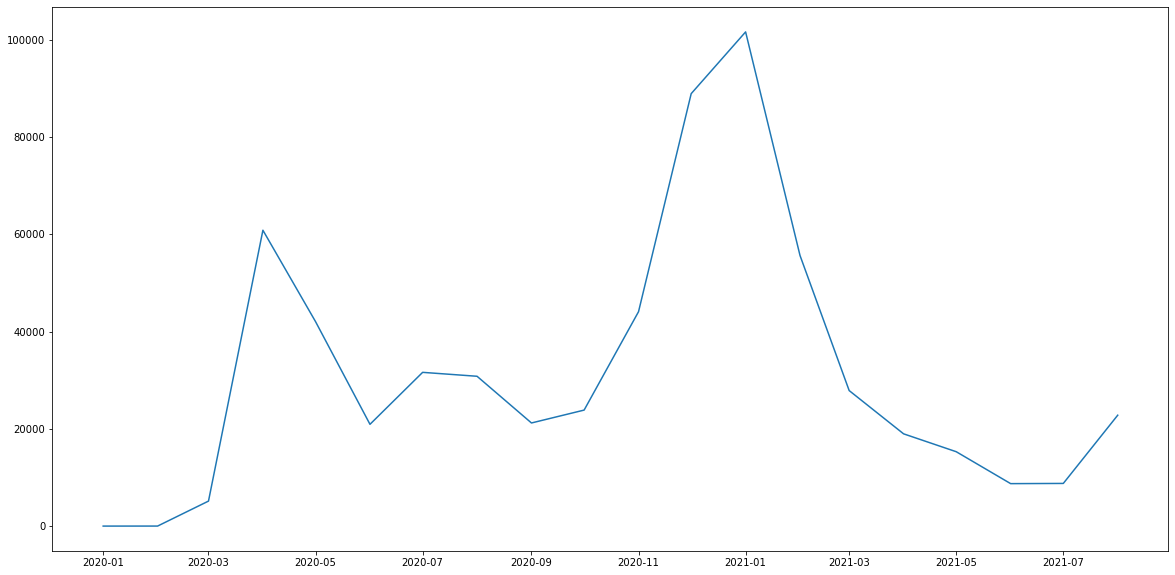

In [27]:
plt.figure(figsize=(20,10))
plt.plot(deaths['submission_date'], deaths['new_death'])

Terribly curious how our case count lines up against the "offical" CDC count in this table.

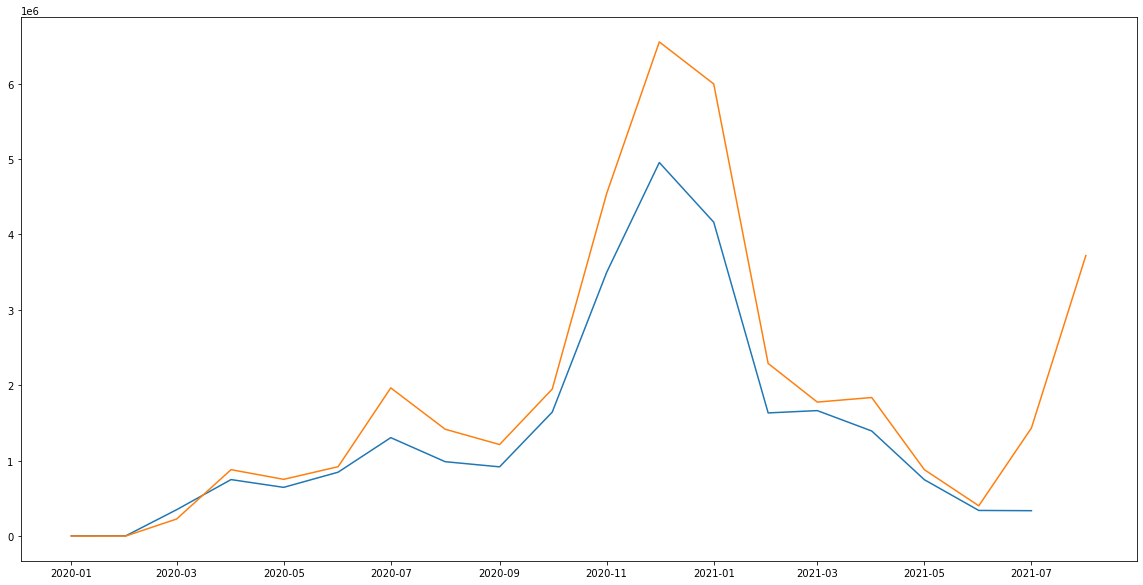

In [28]:
# Just going to eyeball it.
plt.figure(figsize=(20,10))
plt.plot(cases_summary['month'], cases_summary['case_count'])
plt.plot(deaths['submission_date'], deaths['new_case'])

In [29]:
cases_summary = cases_summary.set_index('month').merge(deaths.set_index('submission_date')['new_death'], how='left', left_index=True, right_index=True)

In [30]:
cases_summary['death_pct'] = 100 * cases_summary['new_death'] / cases_summary['case_count']

In [31]:
cases_summary = cases_summary.reset_index()

In [32]:
cases_summary

,month,case_count,patient_count,percent,new_death,death_pct
0,2020-01-01,2330,0,0.000000,0,0.000000
1,2020-02-01,2949,0,0.000000,4,0.135639
2,2020-03-01,349806,0,0.000000,5139,1.469100
3,2020-04-01,749237,0,0.000000,60818,8.117325
4,2020-05-01,646144,0,0.000000,42021,6.503349
5,2020-06-01,847266,0,0.000000,20922,2.469354
6,2020-07-01,1305339,9909,0.759113,31604,2.421134
7,2020-08-01,986424,304285,30.847283,30798,3.122187
8,2020-09-01,918246,267911,29.176386,21198,2.308532
9,2020-10-01,1643809,319098,19.412109,23846,1.450655


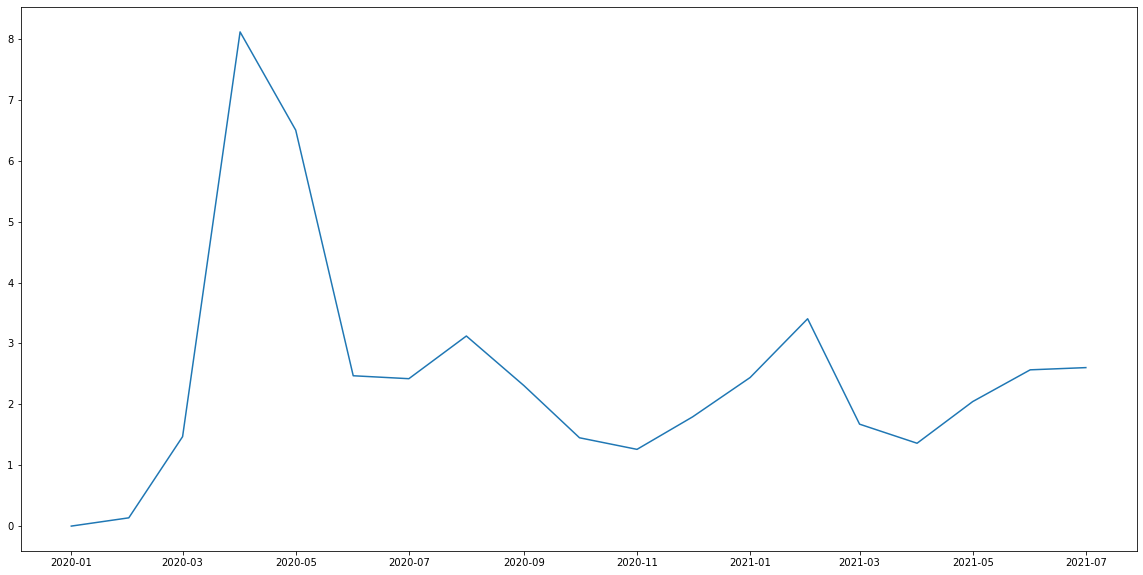

In [33]:
plt.figure(figsize=(20,10))
plt.plot(cases_summary['month'], cases_summary['death_pct'])

In [34]:
cases_adjusted.index.unique(level=0).values

array(['01001', '01003', '01005', ..., '55137', '55139', '55141'],
      dtype=object)

In [35]:
rnd_counties = np.random.choice(cases_adjusted.index.unique(level=0).values, size=8, replace=False)
rnd_counties

array(['04003', '51683', '47053', '21193', '38105', '27115', '37147',
       '08085'], dtype=object)

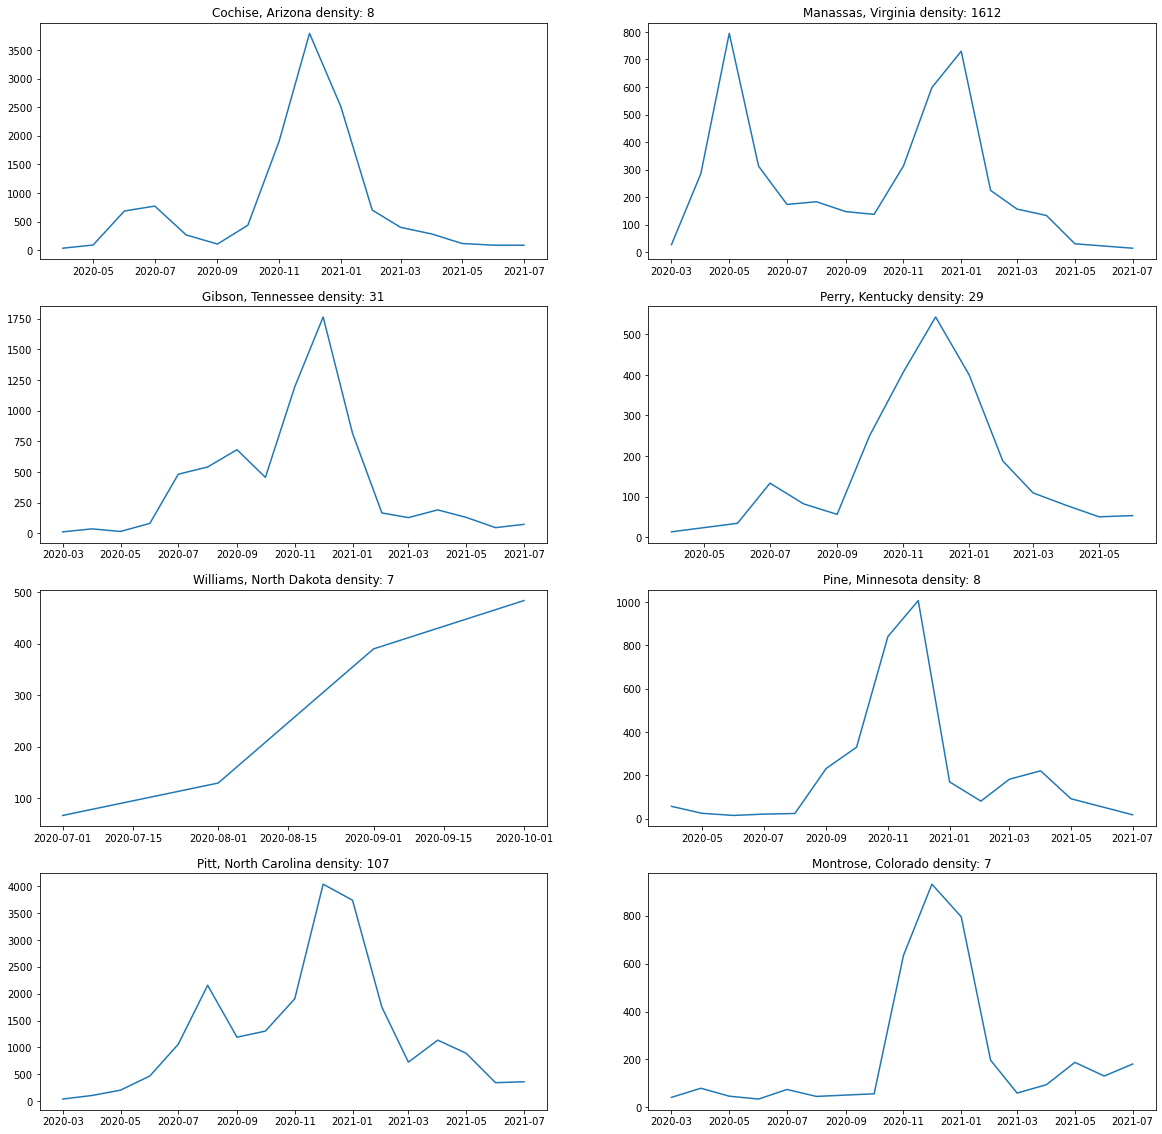

In [36]:
fig, axs = plt.subplots(4, 2, figsize=(20,20))
county_itr = iter(rnd_counties)
for y in np.arange(axs.shape[0]):
    for x in np.arange(axs.shape[1]):
        fips = next(county_itr)
        co = cases_adjusted.loc[fips].reset_index()
        axs[y,x].set_title(f'{reporting_counties.loc[fips, "county_name"]}, {reporting_counties.loc[fips, "state_name"]} density: {reporting_counties.loc[fips, "density"]:.0f}')
        axs[y,x].plot(co['month'].map(lambda x: x.to_timestamp()), co['case_count'])

In [37]:
reporting_counties

,state_name,county_name,area,geometry,hospitals,neighbors,neighbors_wHosp,pop,density
FIPS,,,,,,,,,
21141,Kentucky,Logan,1430224002,"POLYGON ((-87.06037 36.68085, -87.06002 36.708...",[180066],"[47147, 21031, 21177, 21227, 21219, 21213]","[47147, 21177, 21227, 21213]",27102,18.949479
36081,New York,Queens,281594050,"POLYGON ((-73.96262 40.73903, -73.96243 40.739...","[330014, 330055, 330128, 330193, 330231, 330395]","[36005, 36059, 36061, 36047]","[36005, 36059, 36061, 36047]",2253858,8003.926219
34017,New Jersey,Hudson,119640822,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ...","[310003, 310016, 310025, 310040, 310074, 310118]","[34039, 34013, 36061, 34003, 36085]","[34039, 34013, 36061, 34003, 36085]",672391,5620.080076
34019,New Jersey,Hunterdon,1108086284,"POLYGON ((-75.19511 40.57969, -75.19466 40.581...",[310005],"[34027, 34041, 34035, 42017, 34021]","[34027, 34041, 34035, 42017, 34021]",124371,112.239454
21195,Kentucky,Pike,2037621882,"POLYGON ((-82.73269 37.27150, -82.73063 37.273...","[180044, 180069]","[54059, 21071, 51195, 51051, 21119, 21159, 510...","[21071, 51195, 51051, 51027, 21133]",57876,28.403700
...,...,...,...,...,...,...,...,...,...
13285,Georgia,Troup,1072278217,"POLYGON ((-85.23651 33.12956, -85.21581 33.135...",[110016],"[01017, 13145, 13199, 01111, 13149, 13077]","[01017, 13199, 01111, 13077]",69922,65.208823
19181,Iowa,Warren,1475870257,"POLYGON ((-93.79065 41.46502, -93.79061 41.479...",[],"[19117, 19049, 19153, 19121, 19039, 19125]","[19117, 19049, 19153, 19121, 19039, 19125]",51466,34.871629
47021,Tennessee,Cheatham,783480108,"POLYGON ((-87.28196 36.34287, -87.27984 36.348...",[441311],"[47147, 47037, 47187, 47125, 47043]","[47147, 47037, 47187, 47125, 47043]",40667,51.905593


In [38]:
cases_cosummary = cases_adjusted.reset_index().groupby('FIPS')[['case_count', 'patient_count']].sum()

In [39]:
counties_cases = reporting_counties.merge(cases_cosummary, left_index=True, right_index=True)

In [40]:
counties_cases['cases_percap'] = counties_cases['case_count'] / counties_cases['pop']
counties_cases['patients_percap'] = counties_cases['patient_count'] / counties_cases['pop']

In [41]:
counties_cases

,state_name,county_name,area,geometry,hospitals,neighbors,neighbors_wHosp,pop,density,case_count,patient_count,cases_percap,patients_percap
FIPS,,,,,,,,,,,,,
21141,Kentucky,Logan,1430224002,"POLYGON ((-87.06037 36.68085, -87.06002 36.708...",[180066],"[47147, 21031, 21177, 21227, 21219, 21213]","[47147, 21177, 21227, 21213]",27102,18.949479,2147,85,0.079219,0.003136
36081,New York,Queens,281594050,"POLYGON ((-73.96262 40.73903, -73.96243 40.739...","[330014, 330055, 330128, 330193, 330231, 330395]","[36005, 36059, 36061, 36047]","[36005, 36059, 36061, 36047]",2253858,8003.926219,281779,16166,0.125021,0.007173
34017,New Jersey,Hudson,119640822,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ...","[310003, 310016, 310025, 310040, 310074, 310118]","[34039, 34013, 36061, 34003, 36085]","[34039, 34013, 36061, 34003, 36085]",672391,5620.080076,88860,4548,0.132155,0.006764
34019,New Jersey,Hunterdon,1108086284,"POLYGON ((-75.19511 40.57969, -75.19466 40.581...",[310005],"[34027, 34041, 34035, 42017, 34021]","[34027, 34041, 34035, 42017, 34021]",124371,112.239454,10514,904,0.084537,0.007269
21195,Kentucky,Pike,2037621882,"POLYGON ((-82.73269 37.27150, -82.73063 37.273...","[180044, 180069]","[54059, 21071, 51195, 51051, 21119, 21159, 510...","[21071, 51195, 51051, 51027, 21133]",57876,28.403700,5069,2511,0.087584,0.043386
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42001,Pennsylvania,Adams,1343400759,"POLYGON ((-77.47109 39.94408, -77.42136 39.981...",[390065],"[24013, 42055, 42133, 24021, 42041]","[24013, 42055, 42133, 24021, 42041]",103009,76.677789,9700,3327,0.094167,0.032298
13285,Georgia,Troup,1072278217,"POLYGON ((-85.23651 33.12956, -85.21581 33.135...",[110016],"[01017, 13145, 13199, 01111, 13149, 13077]","[01017, 13199, 01111, 13077]",69922,65.208823,6114,3016,0.087440,0.043134
47021,Tennessee,Cheatham,783480108,"POLYGON ((-87.28196 36.34287, -87.27984 36.348...",[441311],"[47147, 47037, 47187, 47125, 47043]","[47147, 47037, 47187, 47125, 47043]",40667,51.905593,4704,0,0.115671,0.000000


## Vaccincations By County

In [42]:
vaccs_raw = pd.read_csv('../../data/CDCdata/COVID-19_Vaccinations_in_the_United_States_County.csv', parse_dates=['Date'])
vaccs_raw

C:\Users\Michael\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (1,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Date,FIPS,MMWR_week,Recip_County,Recip_State,Series_Complete_Pop_Pct,Series_Complete_Yes,Series_Complete_12Plus,Series_Complete_12PlusPop_Pct,Series_Complete_18Plus,...,Administered_Dose1_Recip_12PlusPop_Pct,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_18PlusPop_Pct,Administered_Dose1_Recip_65Plus,Administered_Dose1_Recip_65PlusPop_Pct,SVI_CTGY,Series_Complete_Pop_Pct_SVI,Series_Complete_12PlusPop_Pct_SVI,Series_Complete_18PlusPop_Pct_SVI,Series_Complete_65PlusPop_Pct_SVI
0,2021-08-31,35047,35,San Miguel County,NM,41.4,11282,11282.0,46.5,10404,...,0.0,NaN,0.0,NaN,0.0,High,Mod-High VC/High SVI,Mod-High VC/High SVI,Mod-High VC/High SVI,Mod-High VC/High SVI
1,2021-08-31,38001,35,Adams County,ND,41.0,908,908.0,46.9,896,...,53.1,1003.0,56.1,488.0,77.2,Low,Mod-High VC/Low SVI,Mod-High VC/Low SVI,High VC/Low SVI,High VC/Low SVI
2,2021-08-31,13287,35,Turner County,GA,15.1,1208,1208.0,18.1,1135,...,24.0,1449.0,24.0,446.0,27.9,High,Low VC/High SVI,Low VC/High SVI,Low VC/High SVI,Low VC/High SVI
3,2021-08-31,20019,35,Chautauqua County,KS,34.5,1122,1122.0,39.6,1105,...,44.0,1221.0,46.9,528.0,58.5,Mod-High,Low-Mod VC/Mod-High SVI,Low-Mod VC/Mod-High SVI,Mod-High VC/Mod-High SVI,Mod-High VC/Mod-High SVI
4,2021-08-31,08037,35,Eagle County,CO,67.5,37230,37149.0,77.9,34596,...,86.8,38168.0,88.1,6234.0,91.2,Low,High VC/Low SVI,High VC/Low SVI,High VC/Low SVI,High VC/Low SVI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859637,2020-12-13,5059,51,Hot Spring County,AR,0.0,0,0.0,0.0,0,...,0.0,NaN,0.0,NaN,0.0,High,NaN,NaN,NaN,NaN
859638,2020-12-13,21119,51,Knott County,KY,0.0,0,0.0,0.0,0,...,0.0,NaN,0.0,NaN,0.0,High,NaN,NaN,NaN,NaN
859639,2020-12-13,40085,51,Love County,OK,0.0,0,0.0,0.0,0,...,0.0,NaN,0.0,NaN,0.0,Mod-High,NaN,NaN,NaN,NaN
859640,2020-12-13,46073,51,Jerauld County,SD,0.0,0,0.0,0.0,0,...,0.0,NaN,0.0,NaN,0.0,Low,NaN,NaN,NaN,NaN


In [43]:
vaccs_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859642 entries, 0 to 859641
Data columns (total 27 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   Date                                    859642 non-null  datetime64[ns]
 1   FIPS                                    859642 non-null  object        
 2   MMWR_week                               859642 non-null  int64         
 3   Recip_County                            859642 non-null  object        
 4   Recip_State                             859642 non-null  object        
 5   Series_Complete_Pop_Pct                 859642 non-null  float64       
 6   Series_Complete_Yes                     859642 non-null  int64         
 7   Series_Complete_12Plus                  847855 non-null  float64       
 8   Series_Complete_12PlusPop_Pct           847855 non-null  float64       
 9   Series_Complete_18Plus               

In [44]:
vaccs_raw['FIPS'][0]

'35047'

In [45]:
vaccs_raw['Date'].value_counts()

2021-08-31    3282
2021-03-30    3282
2021-03-28    3282
2021-03-27    3282
2021-03-26    3282
              ... 
2020-12-17    3271
2020-12-16    3257
2020-12-15    3224
2020-12-14    3224
2020-12-13    3224
Name: Date, Length: 262, dtype: int64

In [46]:
vaccs_raw[vaccs_raw['Recip_County'].isin(['Albemarle County', 'Charlottesville city', 'Accomack County']) & (vaccs_raw['Recip_State']=='VA')].groupby("Recip_County")['Series_Complete_Pop_Pct'].first()

Recip_County
Accomack County         53.1
Albemarle County        22.5
Charlottesville city     6.5
Name: Series_Complete_Pop_Pct, dtype: float64

In [47]:
vaccs_raw[vaccs_raw['Recip_County'].isin(['Charlottesville city']) & (vaccs_raw['Recip_State']=='VA')]['Series_Complete_Pop_Pct'].to_numpy()

array([6.5, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.3, 6.3, 6.3, 6.3, 6.2, 6.2,
       6.2, 6.2, 6.2, 6.2, 6.2, 6.1, 6.1, 6.1, 6.1, 6.1, 6.1, 6. , 6. ,
       6. , 6. , 6. , 6. , 6. , 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.8,
       5.8, 5.8, 5.8, 5.8, 5.8, 5.7, 5.7, 5.7, 5.7, 5.7, 5.7, 5.7, 5.6,
       5.6, 5.6, 5.6, 5.6, 5.6, 5.6, 5.6, 5.6, 5.6, 5.6, 5.6, 5.6, 5.5,
       5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.4, 5.4, 5.4, 5.4,
       5.4, 5.4, 5.3, 5.3, 5.2, 5.2, 5.2, 5.2, 5.2, 5.1, 5.1, 5.1, 5.1,
       5.1, 5.1, 5.1, 5. , 5. , 5. , 4.9, 4.9, 4.9, 4.9, 4.8, 4.7, 4.7,
       4.6, 4.6, 4.6, 4.6, 4.4, 4.3, 4.2, 4. , 4. , 3.9, 3.6, 3.4, 3.1,
       3.1, 2.8, 2.8, 2.7, 2.7, 2.4, 2.3, 2.1, 2. , 2. , 2. , 1.9, 1.8,
       1.7, 1.6, 1.5, 1.5, 1.5, 1.5, 1.4, 1.4, 1.3, 1.3, 1.3, 1.2, 1.2,
       1.1, 1. , 1. , 1. , 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.3, 0.

In [48]:
va_vaccs = vaccs_raw[vaccs_raw['Recip_State']=='VA'].groupby('FIPS')['Series_Complete_Pop_Pct'].first()

In [49]:
counties_va = counties[counties['state_name']=='Virginia']
counties_va = counties_va.merge(va_vaccs, how='left', left_index=True, right_index=True)
counties_va

,state_name,county_name,area,geometry,hospitals,neighbors,neighbors_wHosp,pop,density,Series_Complete_Pop_Pct
FIPS,,,,,,,,,,
51105,Virginia,Lee,1127622846,"POLYGON ((-83.67461 36.60308, -83.67390 36.603...",[],"[51195, 21013, 47025, 21095, 47067, 51169]","[51195, 21013, 47025, 21095, 47067]",23423,20.772016,38.0
51141,Virginia,Patrick,1250846155,"POLYGON ((-80.62560 36.60619, -80.62289 36.607...",[],"[37171, 51035, 51063, 51067, 51089, 37169]","[37171, 51067, 37169]",17608,14.076871,23.8
51191,Virginia,Washington,1453483684,"POLYGON ((-82.33034 36.71100, -82.32880 36.711...",[490053],"[47091, 51167, 47163, 51520, 51077, 51173, 51169]","[47091, 51167, 47163, 51173]",53740,36.973239,36.3
51095,Virginia,James City,368550683,"POLYGON ((-76.91423 37.35679, -76.91214 37.359...",[490143],"[51199, 51127, 51036, 51097, 51073, 51700, 51830]","[51199, 51127, 51073, 51700]",76523,207.632230,7.7
51159,Virginia,Richmond,495925426,"POLYGON ((-76.93804 38.08543, -76.93619 38.084...",[],"[51193, 51057, 51103, 51133]","[51057, 51103]",9023,18.194268,8.4
...,...,...,...,...,...,...,...,...,...,...
51049,Virginia,Cumberland,770454314,"POLYGON ((-78.46509 37.33968, -78.43349 37.383...",[],"[51007, 51029, 51147, 51145, 51075, 51065]",[51147],9932,12.891095,6.0
51810,Virginia,Virginia Beach,633828628,"POLYGON ((-76.22516 36.83705, -76.22606 36.839...","[490057, 490119]","[37053, 51710, 51550]","[51710, 51550]",449974,709.930066,36.5
51065,Virginia,Fluvanna,743630407,"POLYGON ((-78.49077 37.79759, -78.49057 37.797...",[],"[51003, 51029, 51109, 51075, 51049]",[51003],27270,36.671443,40.4


<AxesSubplot:>

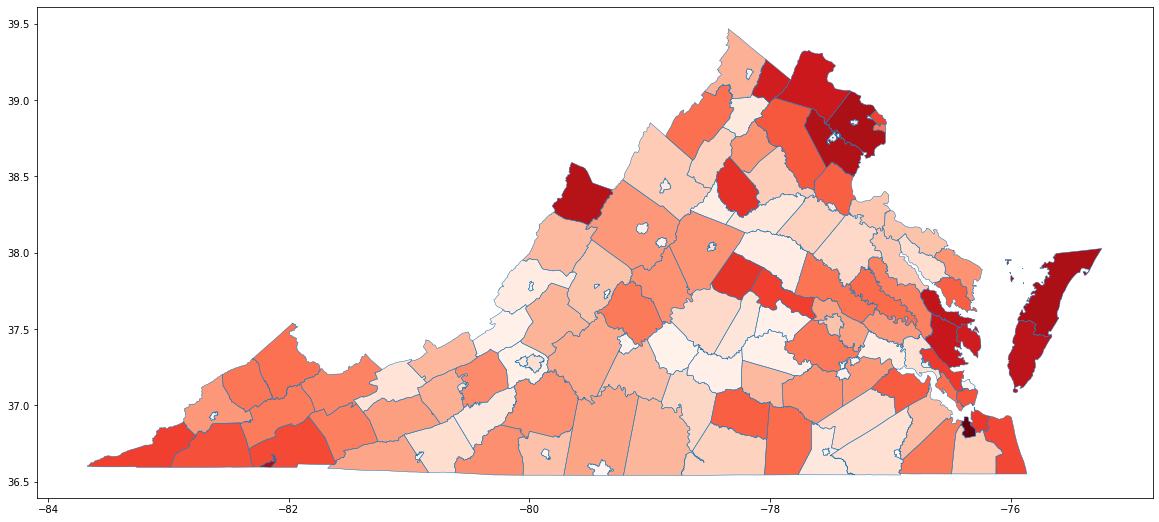

In [50]:
base = counties_va.boundary.plot(figsize=(20,20), linewidth=0.5)
counties_va.plot(column=counties_va['Series_Complete_Pop_Pct'], cmap='Reds', ax=base)

# Being a resident of Virginia, I can see these vaccination rate data are bogus.